## Agglomerative clustering with scipy

In [1]:
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.cluster import hierarchy

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme()
plt.rcParams['figure.figsize'] = [9, 5]

In [2]:
# Set up the collors for hierarchical clustering
tab10_colors = plt.cm.tab10.colors  
tab10_as_hex = [mcolors.to_hex(color) for color in tab10_colors]
hierarchy.set_link_color_palette(tab10_as_hex)

### Artificial dataset

In [6]:
# Create artificial dataset
X, labels = make_blobs(
    n_samples=120, centers=4, cluster_std=0.5, random_state=45
)

data_df = pd.DataFrame(X, columns=['dim1', 'dim2'])
data_df.head()

,dim1,dim2
0,9.925071,0.554242
1,-2.031917,-0.802822
2,-4.624159,-9.173519
3,9.074243,0.855616
4,-4.706691,-8.297154


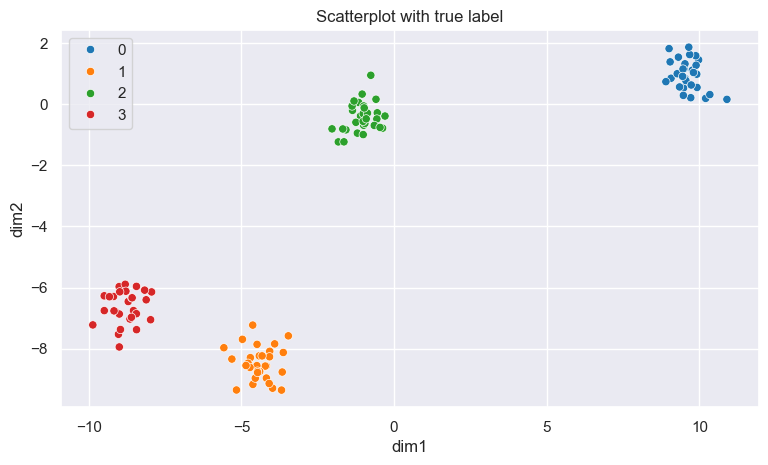

In [7]:
# Plot and colour based on reference label
sns.scatterplot(data_df, x='dim1', y='dim2', hue=labels, palette='tab10')
_ = plt.title('Scatterplot with true label')
plt.gca().set_aspect('equal', adjustable='box')

### "Height cut" based clustering

In [9]:
linkage_matrix = linkage(data_df, method='average')
linkage_matrix[:5]

array([[4.40000000e+01, 6.60000000e+01, 1.18591683e-02, 2.00000000e+00],
       [5.20000000e+01, 7.10000000e+01, 1.46696420e-02, 2.00000000e+00],
       [2.40000000e+01, 9.80000000e+01, 3.22921848e-02, 2.00000000e+00],
       [1.80000000e+01, 3.90000000e+01, 3.53976819e-02, 2.00000000e+00],
       [8.00000000e+00, 9.60000000e+01, 3.83708206e-02, 2.00000000e+00]])

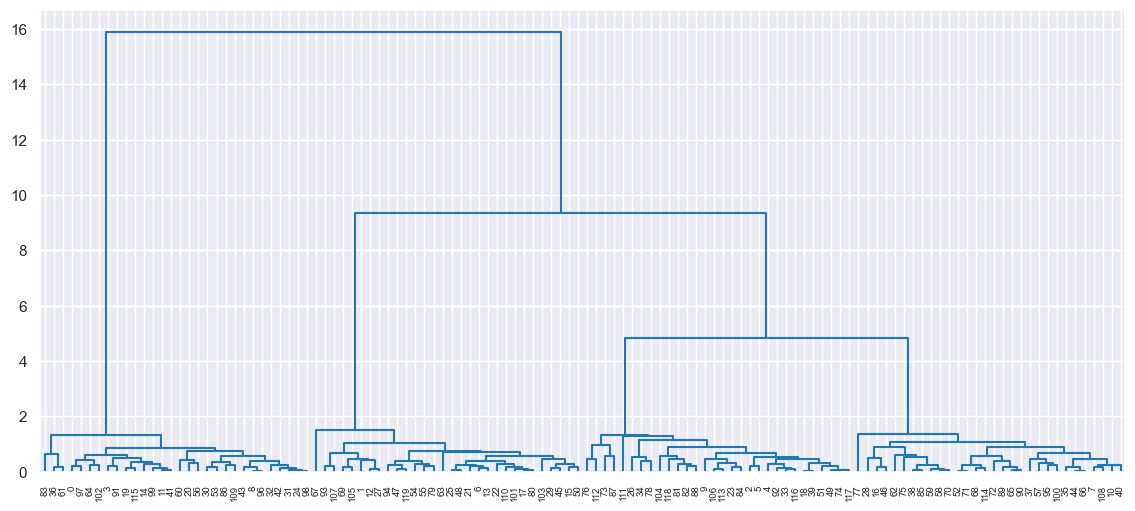

In [10]:
# Draw the dendrogram
plt.figure(figsize=(14,6))
_ = dendrogram(
    linkage_matrix, 
    leaf_font_size=7, 
    labels=data_df.index,
    above_threshold_color='black',
    color_threshold=20
)

In [11]:
cut_height = 4
clusters = fcluster(linkage_matrix, criterion='distance', t=cut_height)

In [12]:
clusters

array([1, 2, 3, 1, 3, 3, 2, 4, 1, 3, 4, 1, 2, 2, 1, 2, 4, 2, 3, 1, 1, 2,
       2, 3, 1, 2, 3, 2, 4, 2, 1, 1, 1, 3, 3, 4, 1, 4, 4, 3, 4, 1, 1, 1,
       4, 2, 4, 2, 2, 3, 2, 3, 4, 1, 2, 2, 1, 4, 4, 4, 1, 1, 4, 2, 1, 4,
       4, 2, 4, 2, 4, 4, 4, 3, 3, 4, 3, 4, 3, 2, 2, 3, 3, 1, 3, 4, 1, 3,
       3, 4, 4, 1, 3, 2, 2, 4, 1, 1, 1, 1, 4, 2, 1, 2, 3, 2, 3, 2, 4, 1,
       2, 3, 3, 3, 4, 1, 3, 3, 3, 2], dtype=int32)

Numbers from 1 to 4, mean we have 4 clusters

Text(0.5, 1.0, 'Cut height = 4')

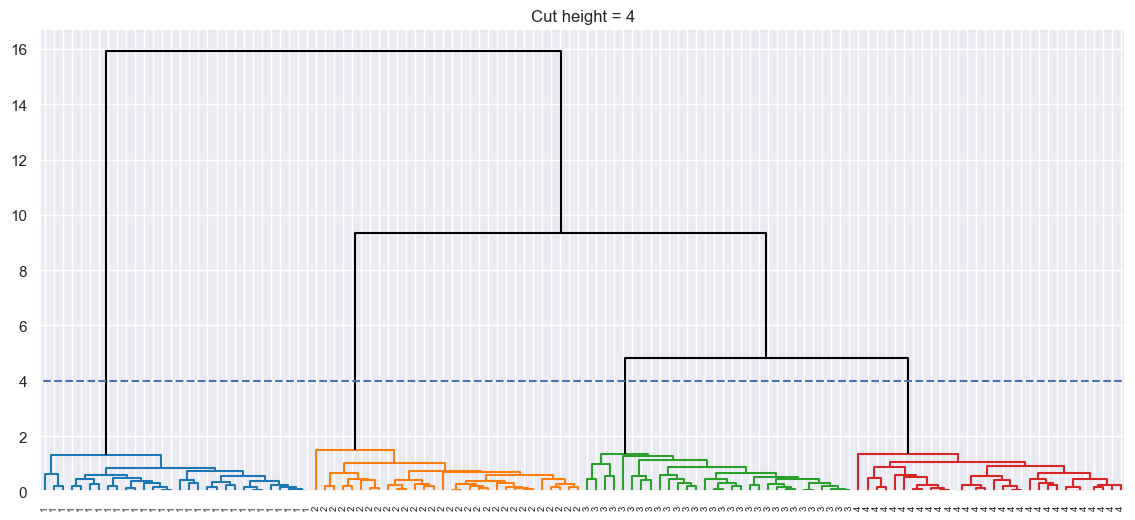

In [13]:
# Draw the dendrogram
plt.figure(figsize=(14,6))
_ = dendrogram(
    linkage_matrix, 
    leaf_font_size=7, 
    labels=clusters, 
    above_threshold_color='black', 
    color_threshold=cut_height
)
plt.hlines(cut_height, xmin=-100, xmax=10000, linestyles='--')
plt.title('Cut height = 4')

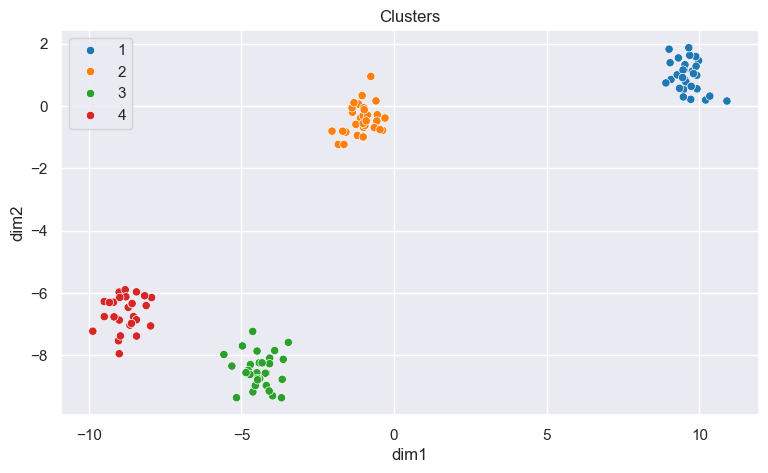

In [14]:
# Plot and colour based on reference label
sns.scatterplot(data_df, x='dim1', y='dim2', hue=clusters, palette='tab10')
_ = plt.title('Clusters')

### Number of clusters based clustering

In [ ]:
plt.figure(figsize=(14,6))
_ = dendrogram(linkage_matrix, color_threshold=20)

In [ ]:
# Cluster based on wanted number of clusters
clusters = fcluster(Z=linkage_matrix, t=4, criterion='maxclust')
clusters

In [ ]:
# Plot and colour based on reference label
sns.scatterplot(data_df, x='dim1', y='dim2', hue=clusters, palette='tab10')
plt.title('Clusters')

### Color the dendrogram based on clustering

In [ ]:
# Get unique clusters
unique_clusters = np.unique(clusters)
# Get first two columns of linkage matrix (representing nodes in nodes)
trunc_linkage = linkage_matrix[:, :2].astype(np.int32)
# Get last "original" point ID
max_orig_point_id = data_df.shape[0] 

# Initialize dict that will hold
# cluster-link relations
cluster_link_dict = {}

# Iterate through all the clusters
for clust in unique_clusters:
    
    # Get all points belonging to current cluster
    clust_points = np.where(clusters==clust)[0]
    
    # Iterate untill we collect all nodes associated
    # with current cluster
    while True:
        
        # Find all positions in linkage matrix where points from the current
        # cluster are present. This positions in linkage matrix also
        # denote IDs of merged nodes (merged node id = position in linkage mtx + max_orig_point_id)
        points_present = np.isin(trunc_linkage, clust_points)
        
        # Sum the matrix in order to find positions where
        # both points belong to current cluster
        present_points_sum = np.sum(points_present,axis=1)
        loc_of_twos = np.where(present_points_sum==2)[0]
        
        # Get node locations
        nodes_to_add = list(loc_of_twos) 
        
        # Variable that will be changed to True
        # if new nodes are added to the dict
        added_new = False
        
        # Iterate through the node
        for node in nodes_to_add:
            
            # Get true ids of the nodes
            node_pos = node + max_orig_point_id
            
            # Add new nodes
            if node_pos not in cluster_link_dict:
                added_new=True
                cluster_link_dict[node_pos] = clust
        
        # If no new nodes are added, this means that all
        # nodes associated with current cluster are already
        # added.
        # In this case break current loop and proceed to the next cluster.
        if not added_new:
            break
        
        # Add merged nodes for next itteration
        new_clust_points = loc_of_twos + max_orig_point_id
        clust_points = np.concatenate([clust_points, new_clust_points])

# Get collor pallete having one color per cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
# Transform colors to hex format (dedrogram function requires it)
colors_hex = [matplotlib.colors.rgb2hex(c) for c in colors]

color_dict = {key: colors_hex[cluster_link_dict[key]-1] for key in cluster_link_dict}

link_color_func = lambda x: color_dict[x] if x in color_dict else 'black'

In [ ]:
patches = [
    mpatches.Patch(color=colors_hex[i], label=str(unique_clusters[i])) 
    for i in range(len(colors_hex))
]

plt.figure(figsize=(14,6))
hierarchy.dendrogram(
    linkage_matrix, 
    link_color_func=link_color_func,
    orientation='top', 
    labels=data_df.index
)
plt.legend(handles=patches, loc='upper left')
plt.title('K = 4')
plt.show()

In [ ]:
# Plot and colour based on reference label
sns.scatterplot(data_df, x='dim1', y='dim2', hue=clusters, palette=colors_hex)
plt.title('Clusters')

In [ ]:
from ch_9_funcs import plot_cluster_dendrogram

### Inconsistency method


In [ ]:
# Calculate inconsistence matrix
depth=4
incosistent_mtx = inconsistent(linkage_matrix, depth)

In [ ]:
incosistent_mtx[:10,:]

In [ ]:
inconsistency_df = pd.DataFrame(
    incosistent_mtx, 
    columns=['mean', 'std', 'num_links', 'inconsistency_coeff']
)
inconsistency_df.tail(10)

In [ ]:
linkage_df = pd.DataFrame(
    linkage_matrix, 
    columns=['First group', 'Second group', 'Distance', 'Size']
)
linkage_df['New id'] = np.arange(linkage_df.shape[0]) + linkage_df.shape[0]+1

linkage_df.tail(10)

In [ ]:
# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))

plt.plot(incosistent_mtx[:,-1])
plt.scatter(
    range(incosistent_mtx.shape[0]),
    incosistent_mtx[:,-1], 
    s=10, c='red'
)

plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [ ]:
# Perform clustering by cutting dendogram based on obtained inconsistency threshold
thold = 2.5
clusters = fcluster(Z=linkage_matrix, t=thold, criterion='inconsistent', R=incosistent_mtx)

plt.figure(figsize=(14,6))
_ = plot_cluster_dendrogram(
    clusters=clusters,
    linkage_matrix=linkage_matrix,
    dataset_df=data_df,
    orientation='top'
)

In [ ]:
# Perform clustering by cutting dendogram based on obtained inconsistency threshold
thold = 2.2
clusters = fcluster(Z=linkage_matrix, t=thold, criterion='inconsistent', R=incosistent_mtx)

plt.figure(figsize=(14,6))
dendr_colors = plot_cluster_dendrogram(
    clusters=clusters,
    linkage_matrix=linkage_matrix,
    dataset_df=data_df,
    orientation='top'
)

In [ ]:
# Plot clustering results
sns.scatterplot(data_df, x='dim1', y='dim2', hue=clusters, palette=dendr_colors)
plt.title('Scatterplot with true label')

In [ ]:
# Perform clustering by cutting dendogram based on obtained inconsistency threshold
thold = 2.5
clusters = fcluster(Z=linkage_matrix, t=thold, criterion='inconsistent', R=incosistent_mtx)

## Silouethe score

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
y_lower = 10

# Calculate average silhouette score
silhouette_scr = silhouette_score(data_df, clusters)

# Calculate silhouette score for each data point
sample_silhouette_values = silhouette_samples(data_df, clusters)

# Plot clustering and silouethes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

num_clust = np.unique(clusters).shape[0]

if 0 in clusters:
    adjust_factor = 0
else:
    adjust_factor = 1

# Plot siluethe scores for points belonging to each cluster
for clust_i in range(num_clust):
    
    # Get points bellogning to the current cluster
    ith_cluster_silhouette_values = sample_silhouette_values[
        clusters == clust_i + adjust_factor
    ]
    
    # Sort points by silhouette value
    ith_cluster_silhouette_values.sort()
    
    # Get size of current cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    
    # Get upper value of y cooridnate for current cluster
    y_upper = y_lower + size_cluster_i
    
    # Fill values between y_lower and y_upper with silhouette score values
    # for data points

    color = dendr_colors[clust_i]

    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i + adjust_factor))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

# Set title and labels silhouette subplot
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_scr, color="red", linestyle="--")

# Clear the yaxis labels / ticks
ax1.set_yticks([]) 
# Set x-ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Map cluster labels to cluster colors, nipy_spectral provides

colors = [dendr_colors[clust_i-adjust_factor] for clust_i in clusters]

# 2nd Plot showing the actual clusters formed
ax2.scatter(
    data_df.to_numpy()[:, 0], 
    data_df.to_numpy()[:, 1],
    marker=".", s=30, lw=0, 
    alpha=0.7, c=colors, 
    edgecolor="k"
)

# Set title and labels for scatterplot
ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("dim1")
ax2.set_ylabel("dim2")

# Add main title
plt.suptitle(
    "Silhouette analysis for KMeans clustering",
    fontsize=14,
    fontweight="bold",
)

# Show the plot
plt.show()